Martín Amado - 19020
Juan Pablo Pineda - 19087
### Hoja de trabajo 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from apyori import apriori
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
pd.set_option('display.max_rows', None)

## Analisis exploratorio

In [3]:
consumption = pd.read_excel('./CONSUMO-2022-05.xlsx', skiprows=6)
imports = pd.read_excel('./IMPORTACION-VOLUMEN-2022-05.xlsx', skiprows=6)

# Descripcion de los datos de interes

In [4]:
interes=['Gasolina superior', 'Gasolina regular', 'Diesel']
interesF=['Fecha', 'Gasolina superior', 'Gasolina regular', 'Diesel']
consumos = consumption[interesF]
#omitimos los datos despues del 269 ya que no aportan relevancia
consumos = consumos[:269]
importes = imports[interesF]
importes = importes[:257]

In [5]:
consumos.head(10)

,Fecha,Gasolina superior,Gasolina regular,Diesel
0,2000-01-01 00:00:00,308156.82,202645.2,634667.06
1,2000-02-01 00:00:00,307766.31,205530.96,642380.66
2,2000-03-01 00:00:00,331910.29,229499.56,699807.25
3,2000-04-01 00:00:00,315648.08,210680.4,586803.98
4,2000-05-01 00:00:00,319667.97,208164.34,656948.2
5,2000-06-01 00:00:00,300347.7,195088.74,570919.88
6,2000-07-01 00:00:00,308305.93,204556.77,576436.02
7,2000-08-01 00:00:00,323011.86,218388.51,593770.77
8,2000-09-01 00:00:00,326455.72,213906.96,590145.4
9,2000-10-01 00:00:00,323843.63,213606.65,641113.36


In [6]:
importes.head(10)

,Fecha,Gasolina superior,Gasolina regular,Diesel
0,2001-01-01,373963.96,177776.5,566101.99
1,2001-02-01,243091.07,123115.99,489525.8
2,2001-03-01,312084.38,161726.42,575559.68
3,2001-04-01,285054.89,127338.74,437745.42
4,2001-05-01,300913.67,168730.19,552609.13
5,2001-06-01,333217.19,152899.09,497855.26
6,2001-07-01,195071.86,136299.13,302350.02
7,2001-08-01,268153.26,139365.07,464159.13
8,2001-09-01,308439.07,233643.75,321952.94
9,2001-10-01,305102.28,141550.22,438989.55


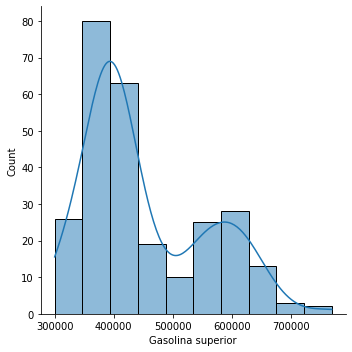

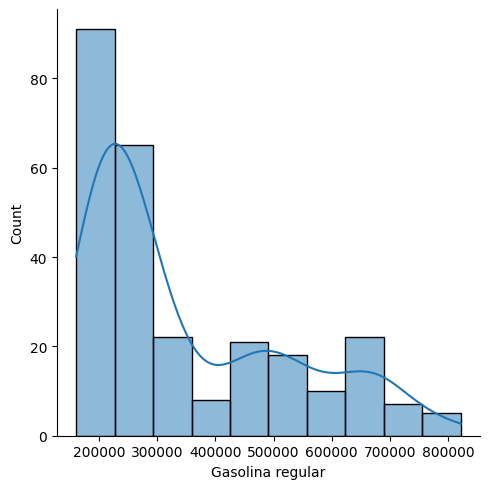

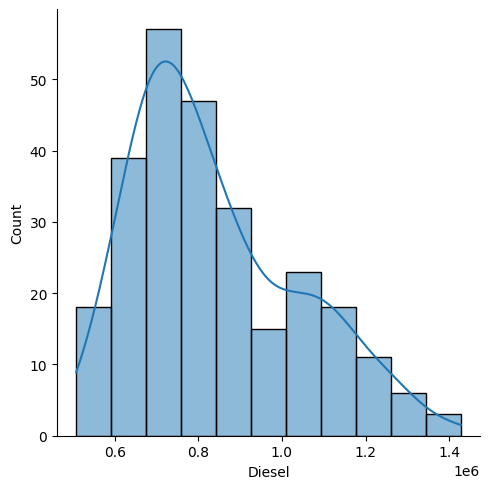

In [7]:
for var in interes:
    sns.displot(consumos[var], kde=True)

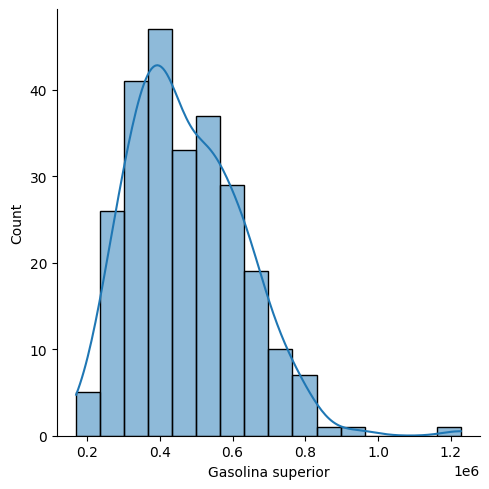

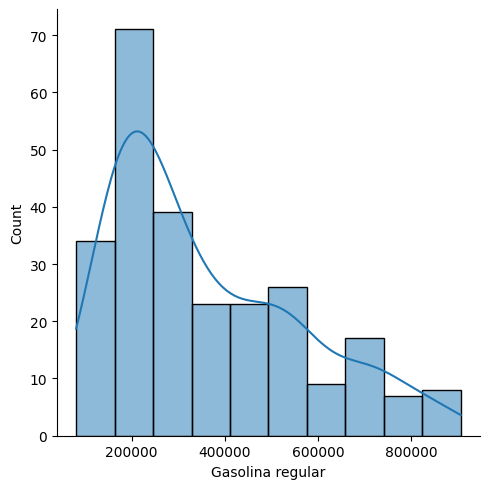

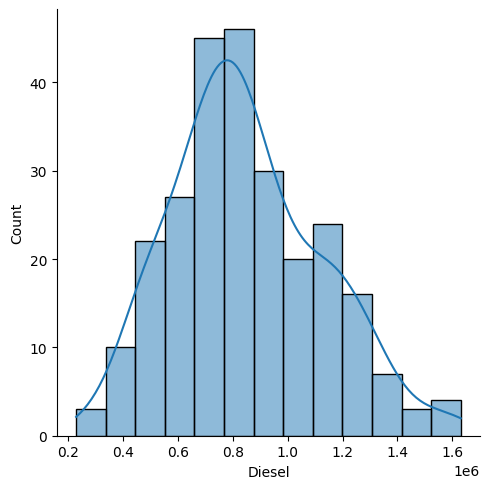

In [8]:
for var in interes:
    sns.displot(importes[var], kde=True)

In [9]:
fechaConsumo = [pd.to_datetime(d) for d in consumos['Fecha']]
consumos['Fecha'] = fechaConsumo
fechaImportes = [pd.to_datetime(d) for d in importes['Fecha']]
importes['Fecha'] = fechaImportes

Separamos los datos en fechas 

In [10]:
fechasC = pd.DataFrame()
fechasC['consumptionDate'] = fechaConsumo
fechasC['year'] = fechasC['consumptionDate'].dt.year
fechasC['month'] = fechasC['consumptionDate'].dt.month


fechasI = pd.DataFrame()
fechasI['consumptionDate'] = fechaImportes
fechasI['year'] = fechasI['consumptionDate'].dt.year
fechasI['month'] = fechasI['consumptionDate'].dt.month


# Pico de consumo por mes

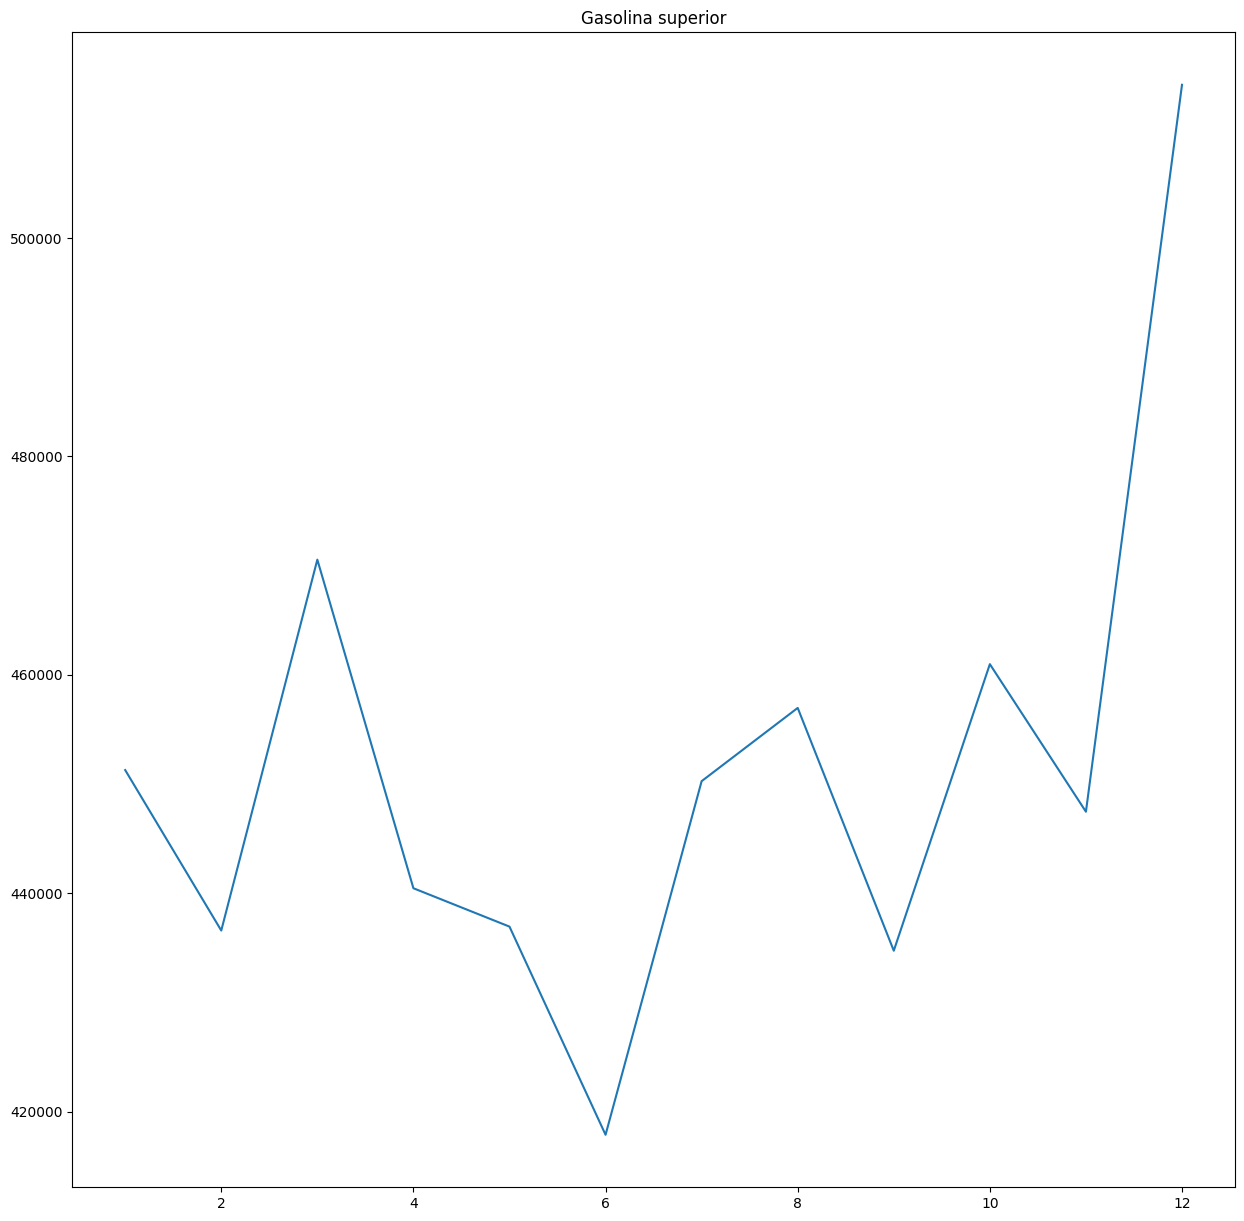

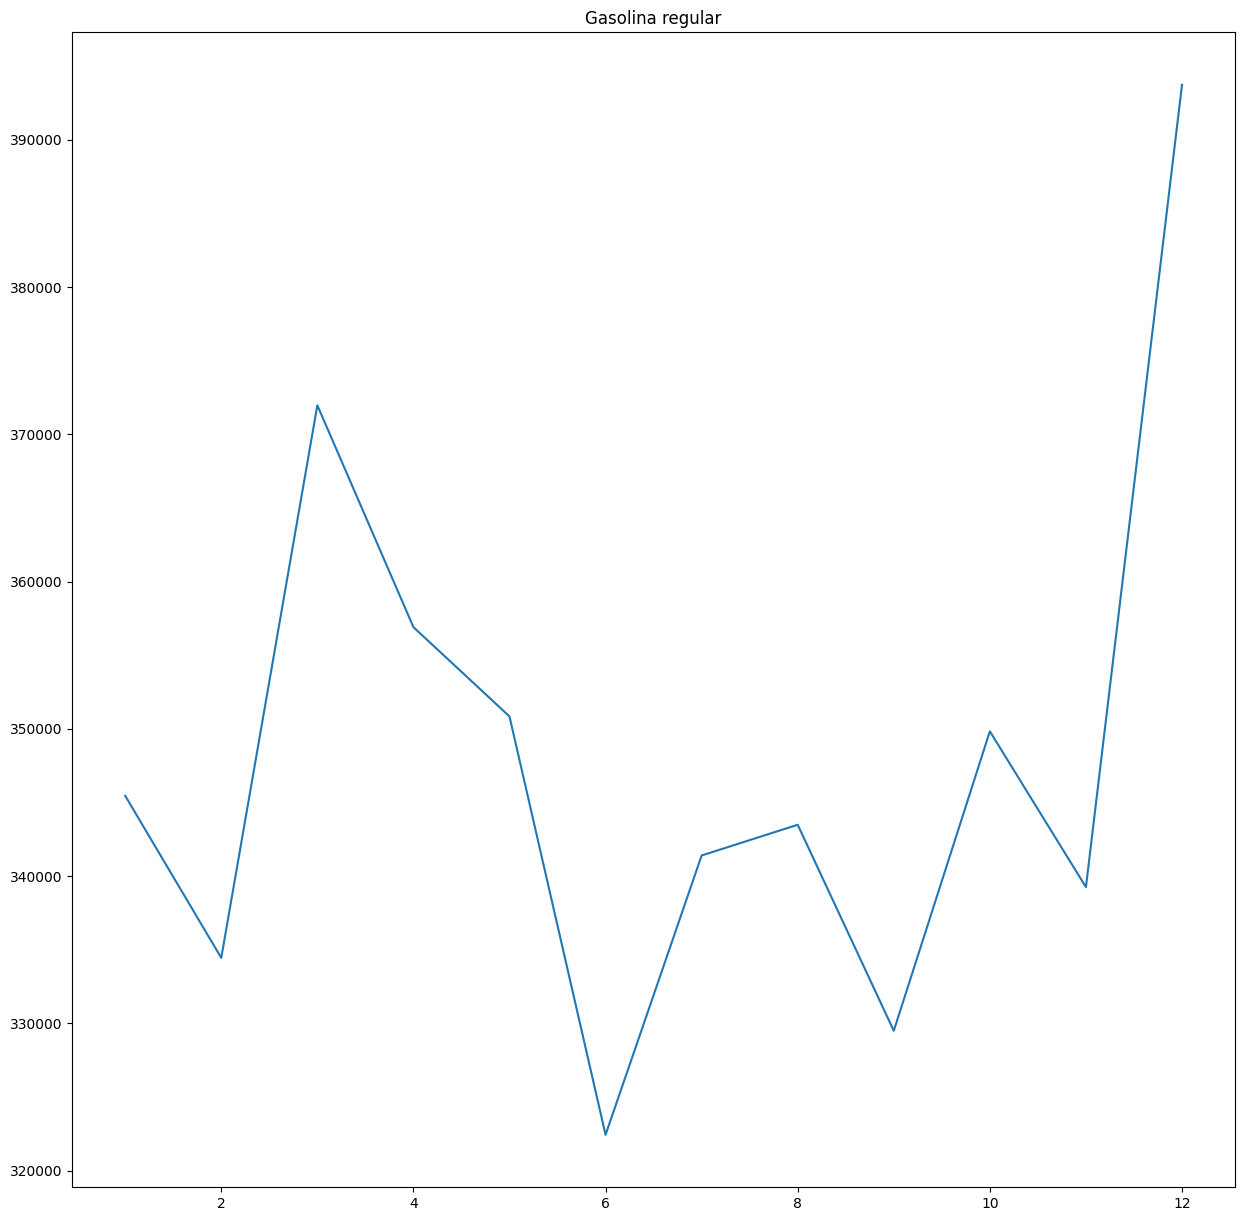

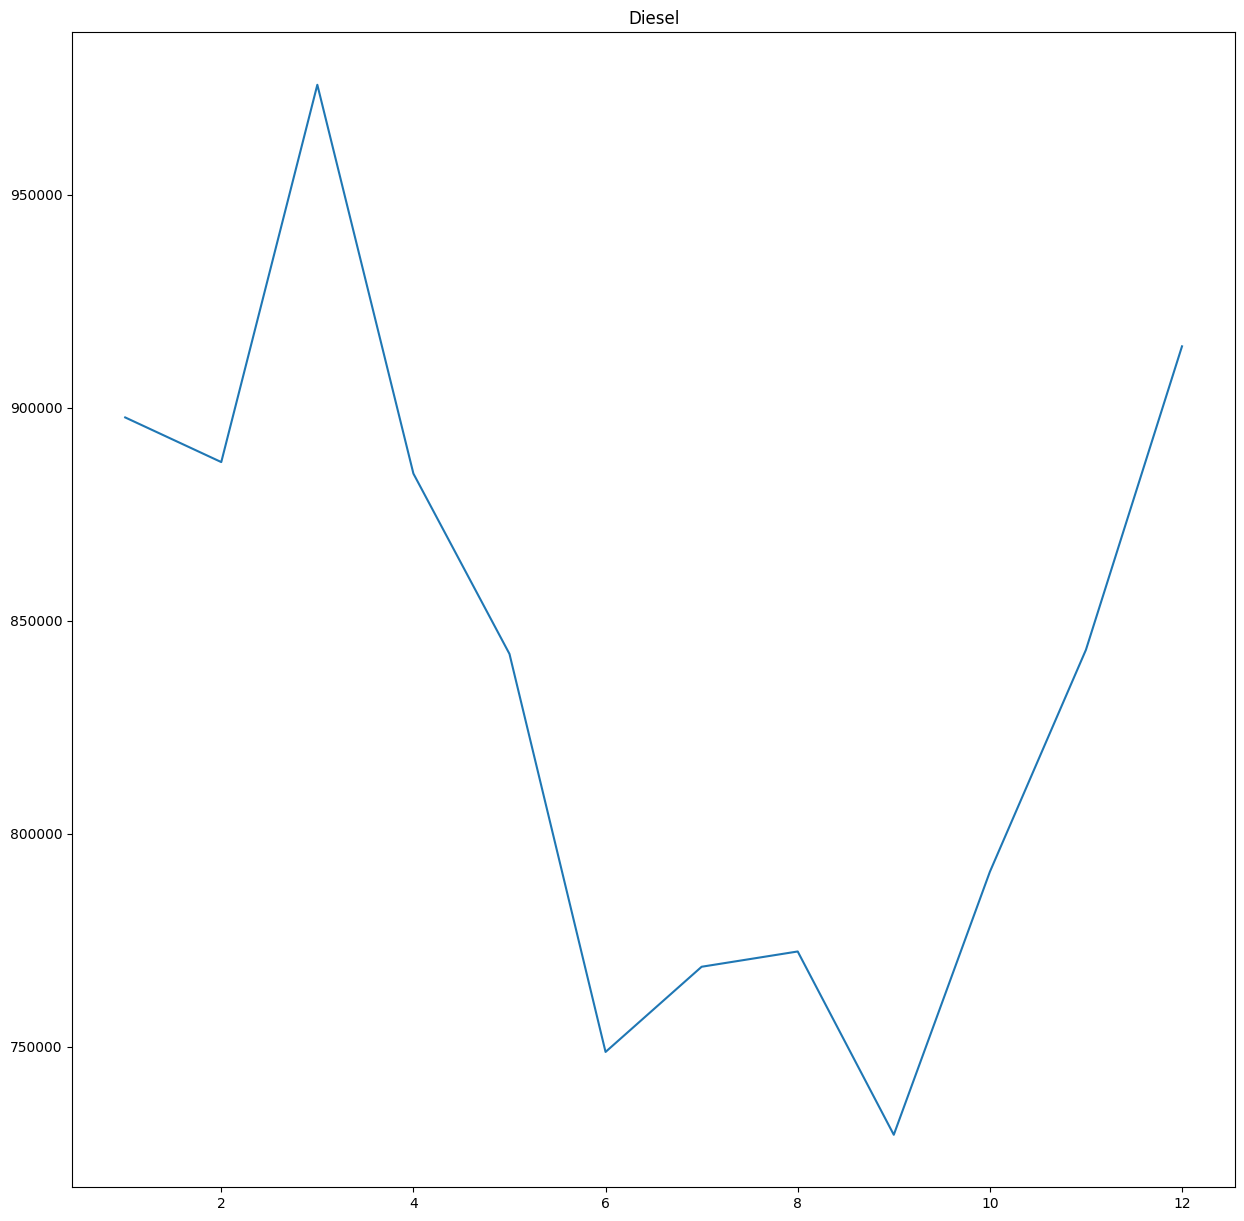

In [11]:
monthlyData = consumos.groupby(consumos['Fecha'].dt.month)
months = []
for name, group in monthlyData:
    months.append(name)

for x in interes:
    figure = plt.figure()
    figure.set_figwidth(15)
    figure.set_figheight(15)
    plt.title(x)
    plt.plot(months, monthlyData.mean()[x])
    plt.show()
    


# Pico de importaciones por mes

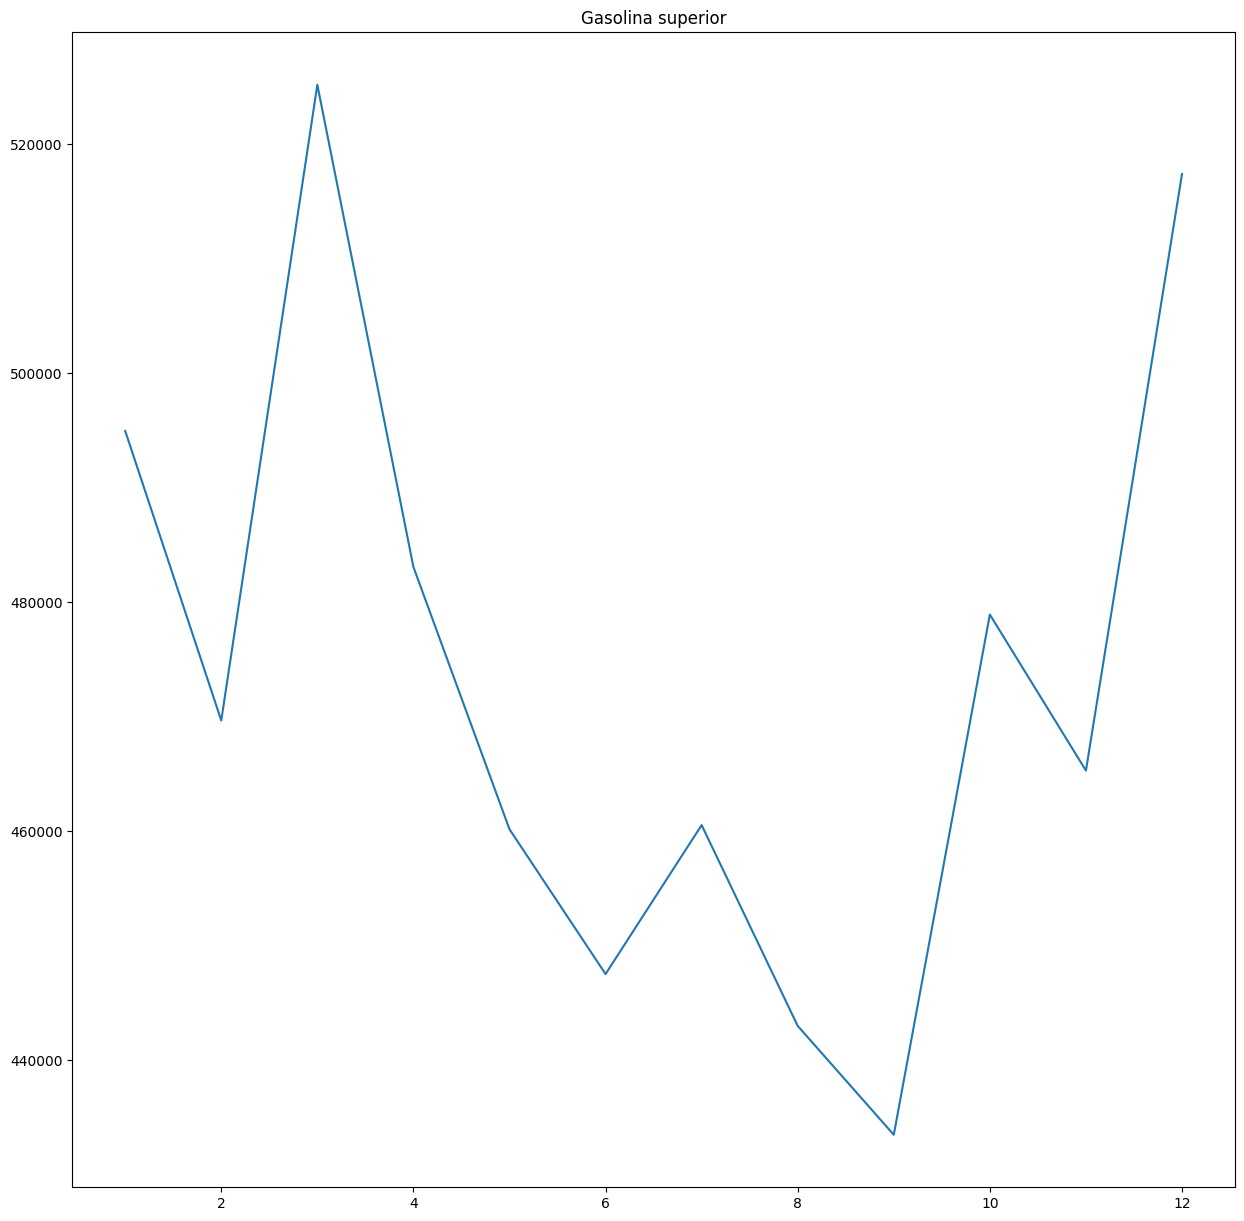

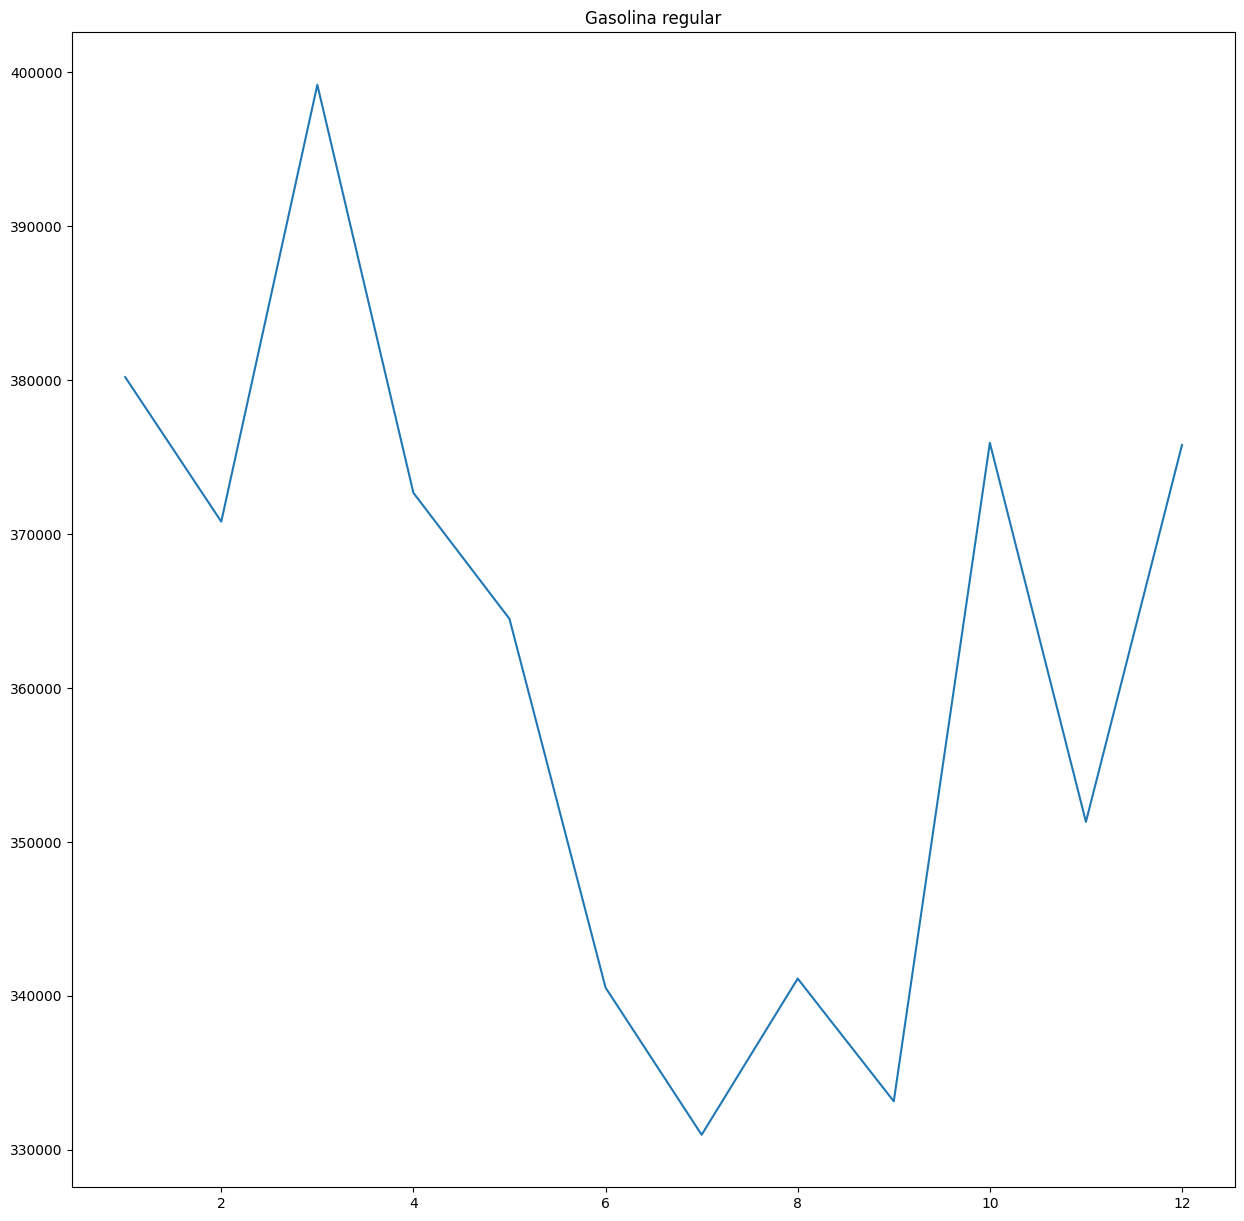

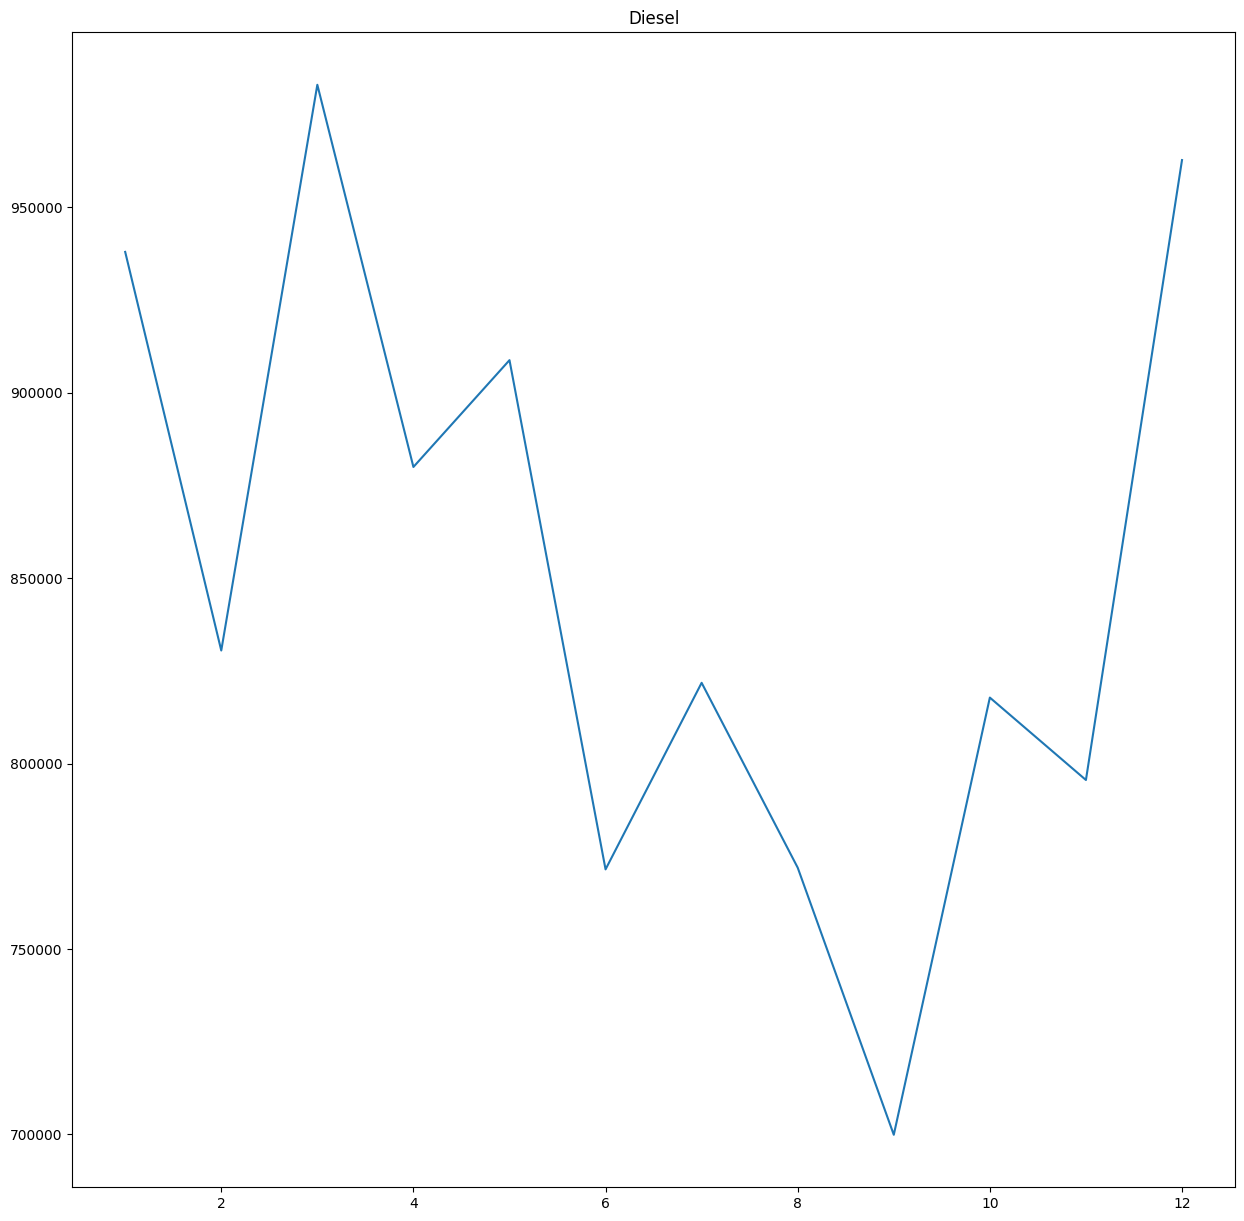

In [12]:
monthlyData = importes.groupby(importes['Fecha'].dt.month)
months = []
for name, group in monthlyData:
    months.append(name)

for x in interes:
    figure = plt.figure()
    figure.set_figwidth(15)
    figure.set_figheight(15)
    plt.title(x)
    plt.plot(months, monthlyData.mean()[x])
    plt.show()
    


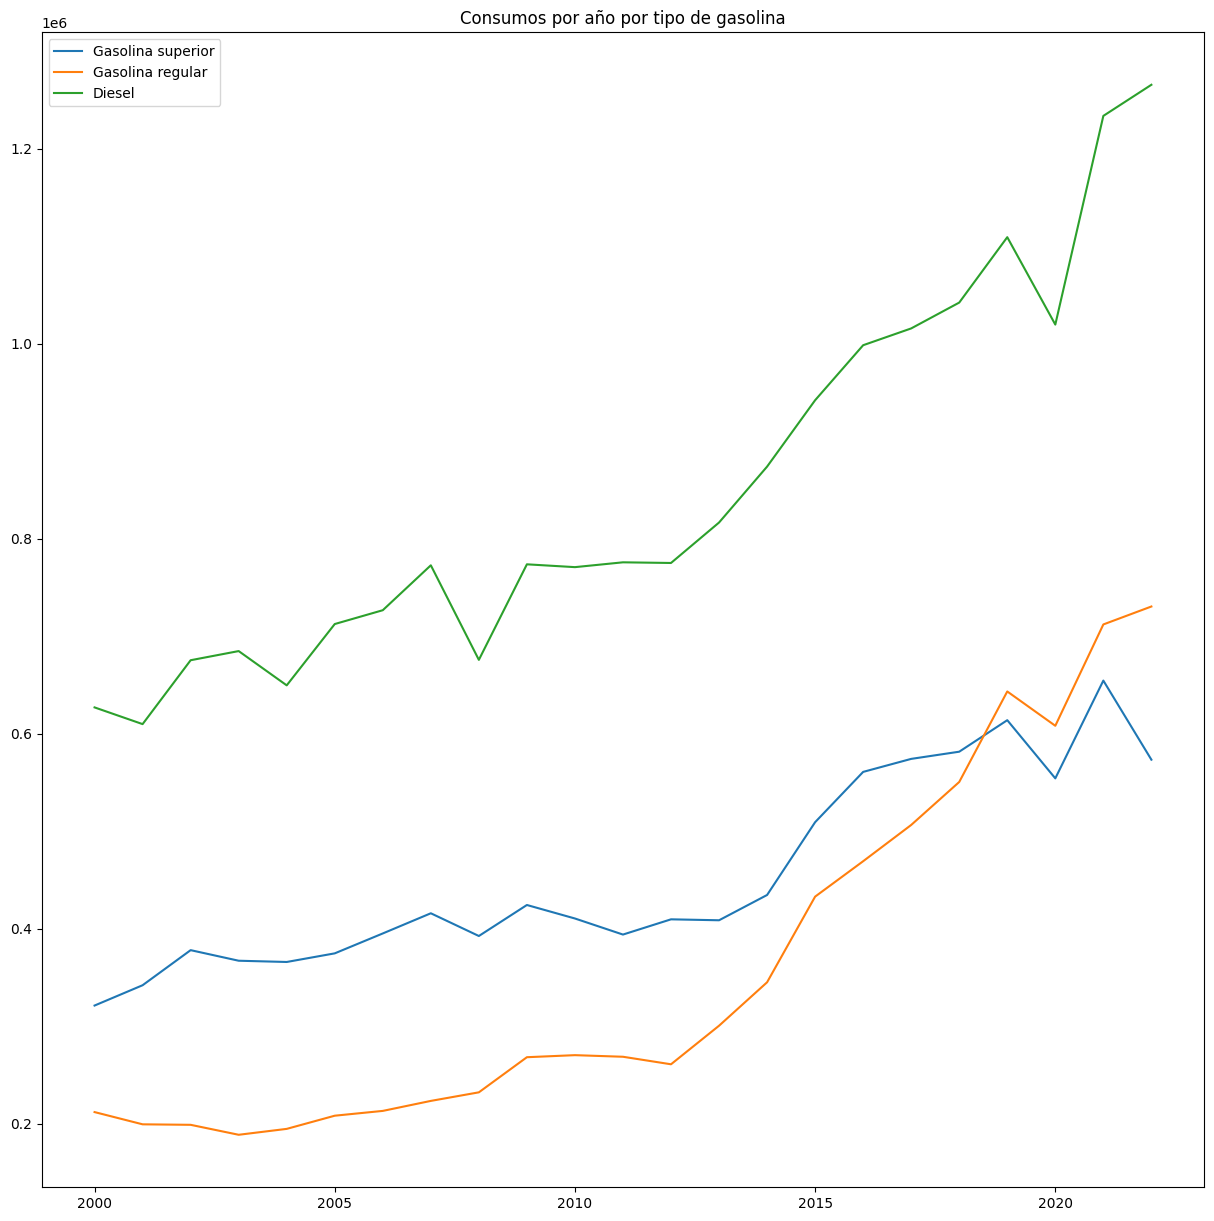

In [13]:
yearData = consumos.groupby(consumos['Fecha'].dt.year)
years = []
for name, group in yearData:
    years.append(name)

figure = plt.figure()
figure.set_figwidth(15)
figure.set_figheight(15)
for x in interes:
    plt.plot(years, yearData.mean()[x], label=x)

plt.title('Consumos por año por tipo de gasolina')
plt.legend()
plt.show()


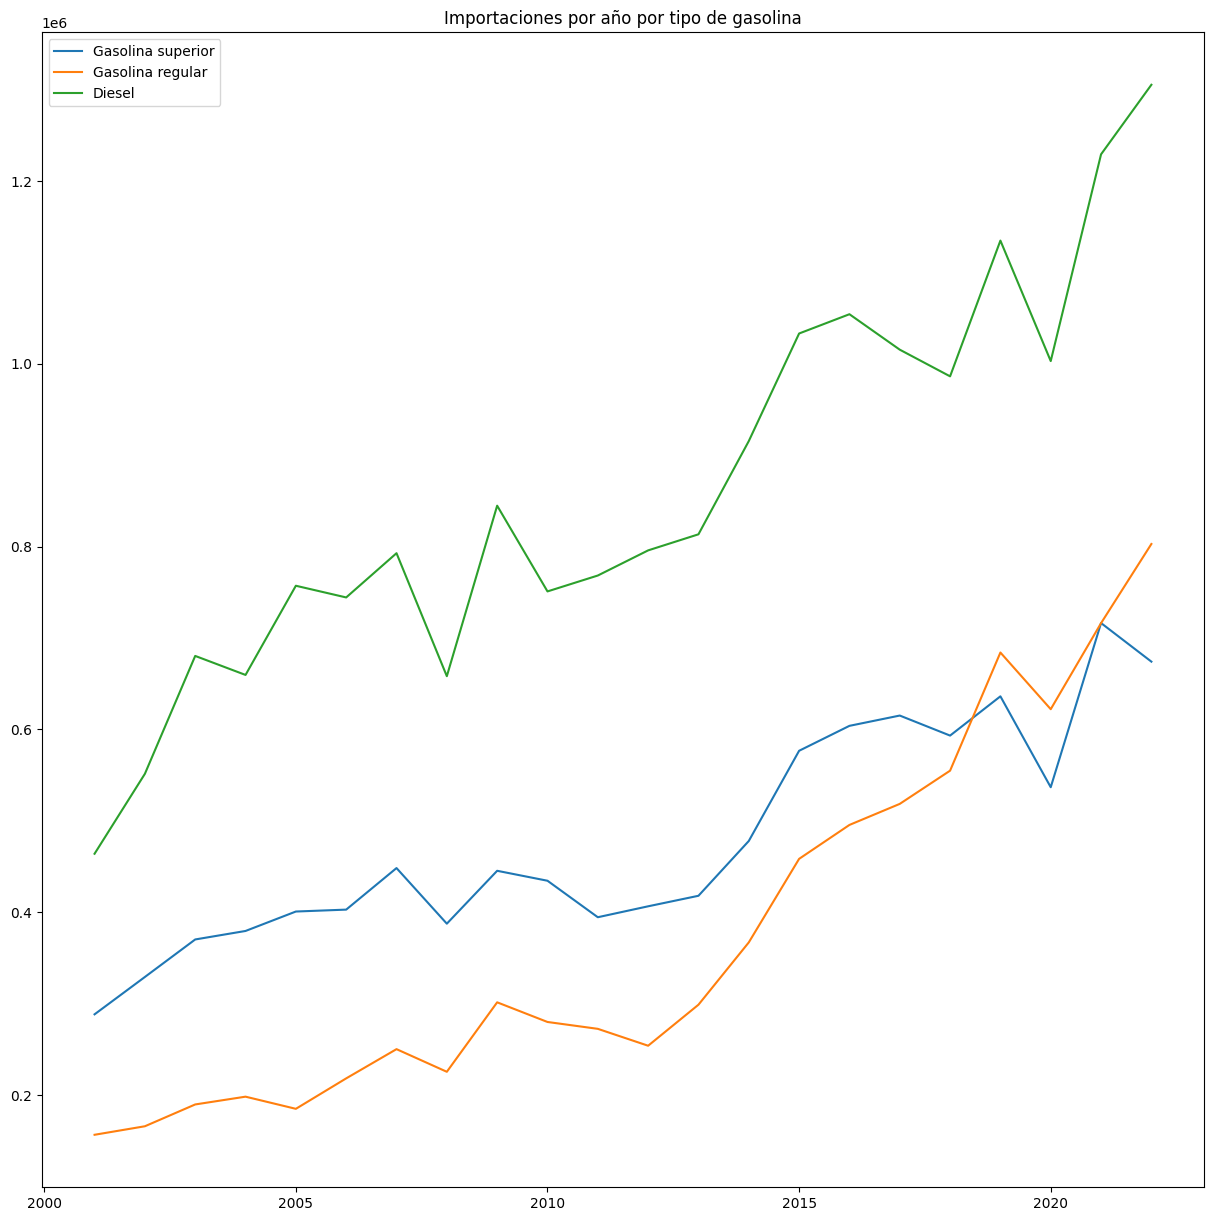

In [14]:
yearData = importes.groupby(importes['Fecha'].dt.year)
years = []
for name, group in yearData:
    years.append(name)

figure = plt.figure()
figure.set_figwidth(15)
figure.set_figheight(15)
for x in interes:
    plt.plot(years, yearData.mean()[x], label=x)

plt.title('Importaciones por año por tipo de gasolina')
plt.legend()
plt.show()


# Comportamiento de importaciones en 2020

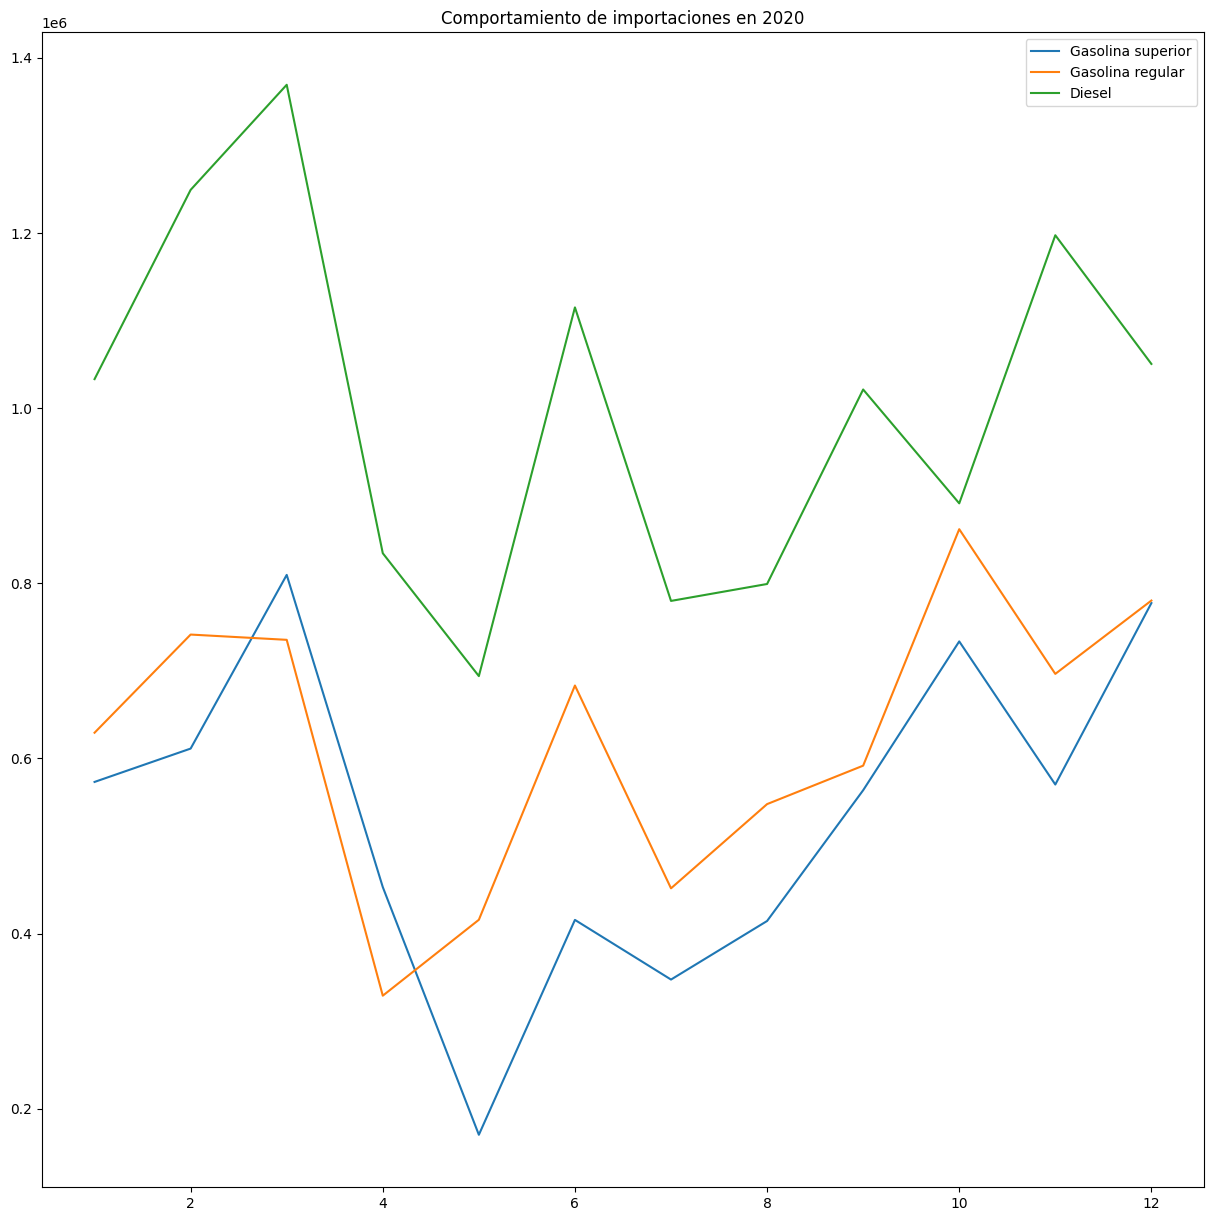

In [15]:
monthlyData = importes.where(importes['Fecha'].dt.year == 2020).groupby(importes['Fecha'].dt.month)
months = []
for name, group in monthlyData:
    months.append(name)

figure = plt.figure()
figure.set_figwidth(15)
figure.set_figheight(15)
for x in interes:
    plt.plot(months, monthlyData.mean()[x], label=x)

plt.title('Comportamiento de importaciones en 2020')
plt.legend()    
plt.show()

# Comportamiento de consumos en 2020

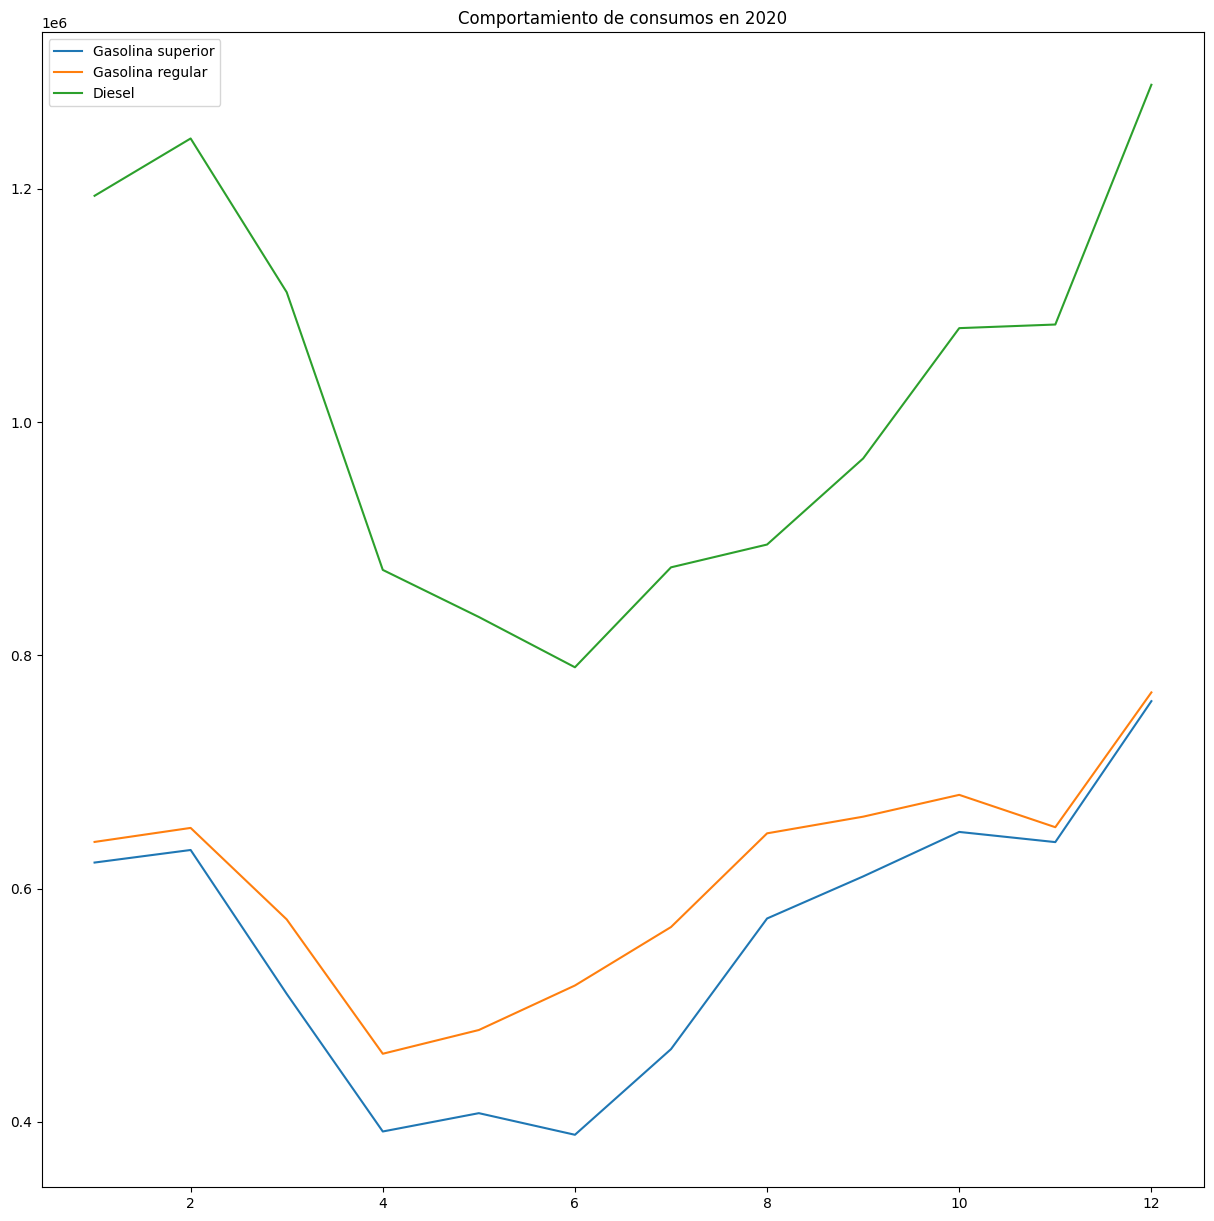

In [16]:
monthlyData = consumos.where(consumos['Fecha'].dt.year == 2020).groupby(consumos['Fecha'].dt.month)
months = []
for name, group in monthlyData:
    months.append(name)

figure = plt.figure()
figure.set_figwidth(15)
figure.set_figheight(15)
for x in interes:
    plt.plot(months, monthlyData.mean()[x], label=x)

plt.title('Comportamiento de consumos en 2020')
plt.legend()    
plt.show()

### Serie de tiempo

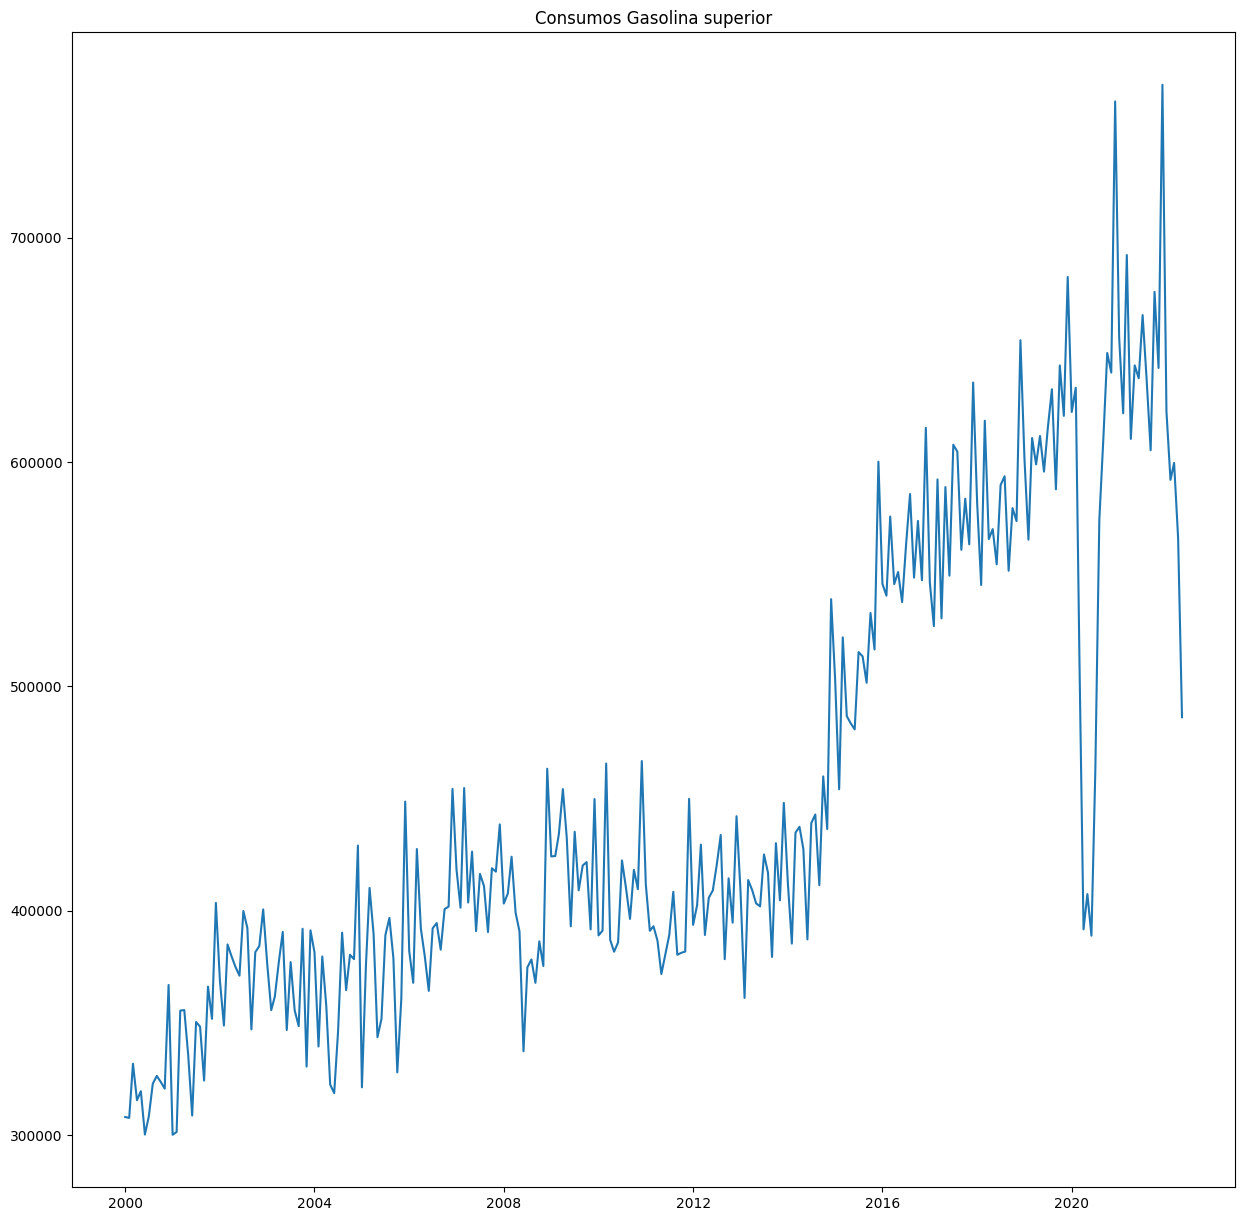

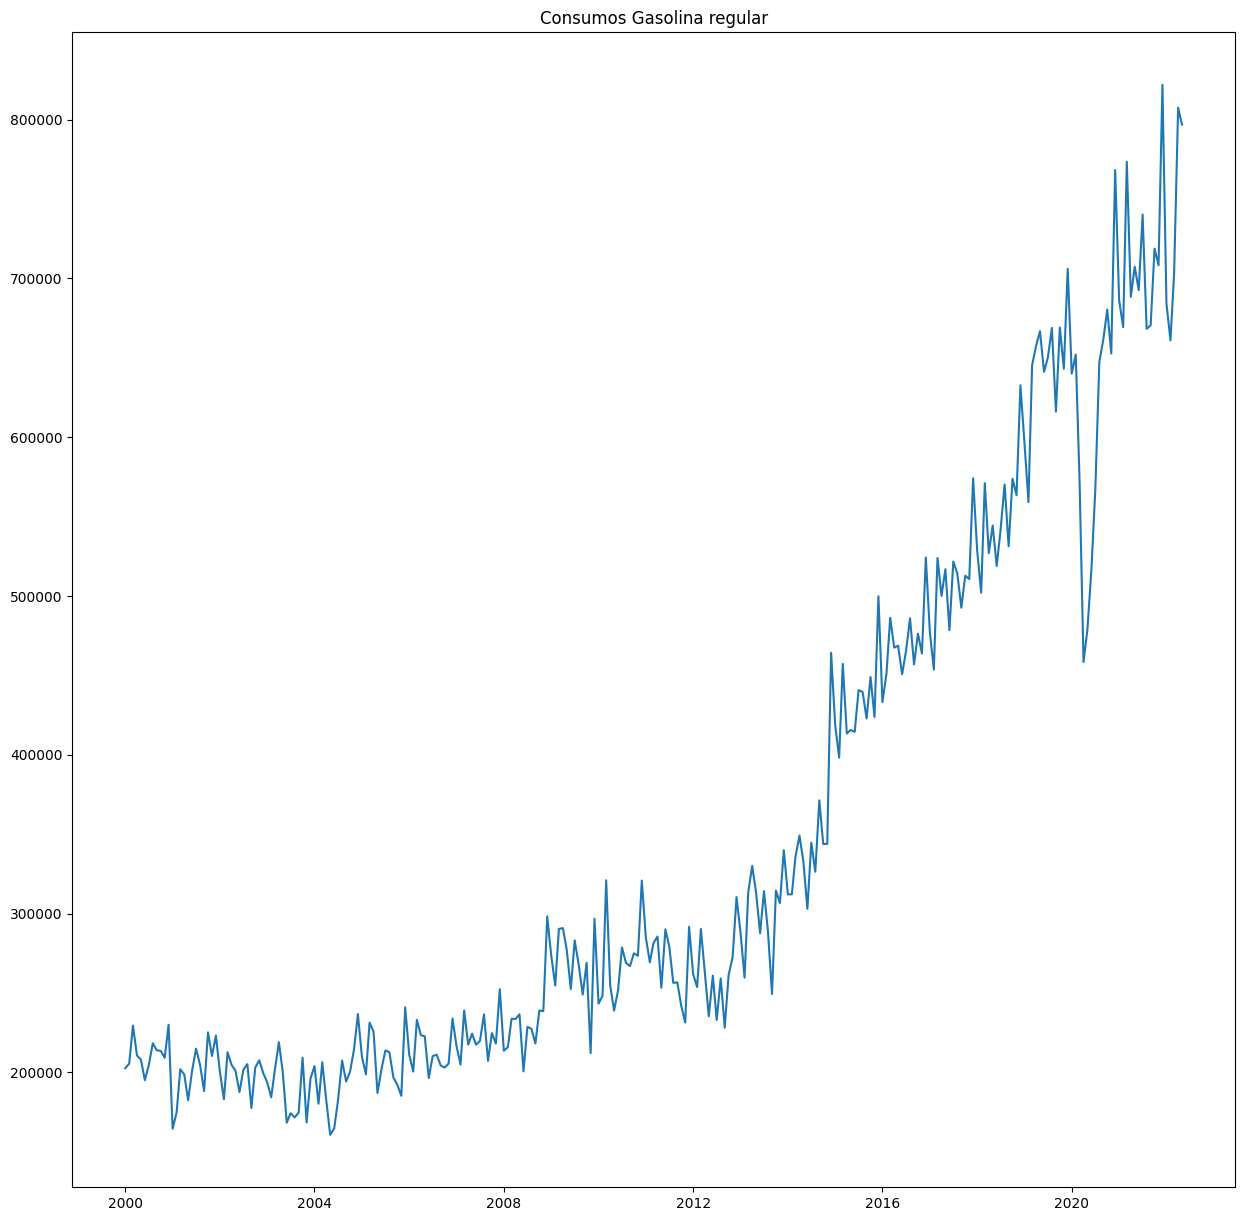

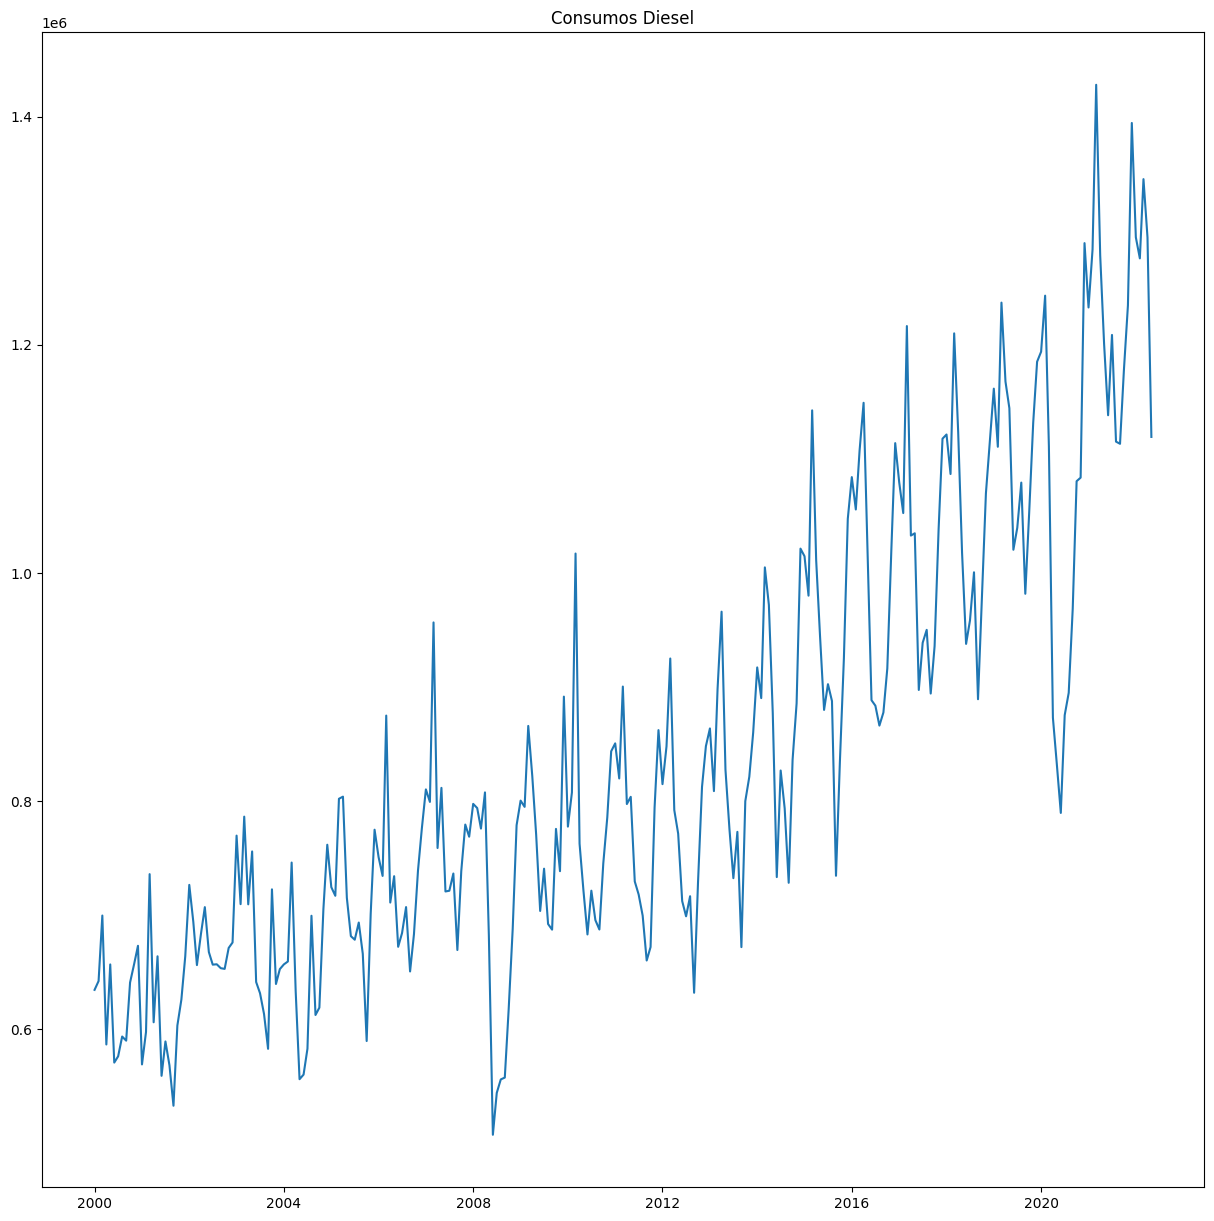

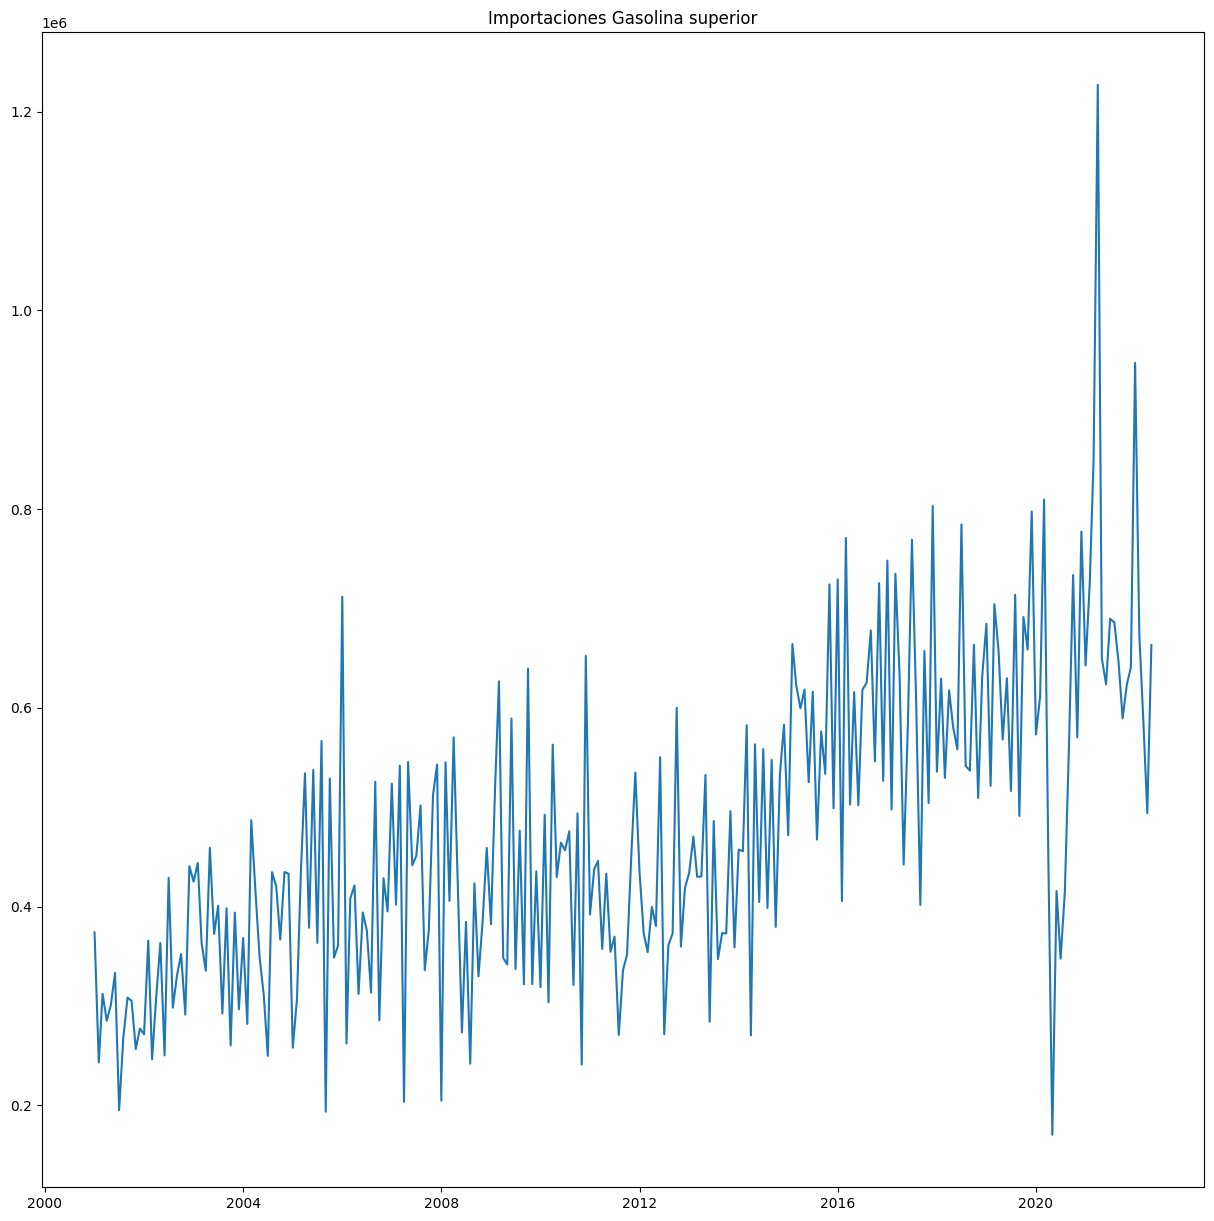

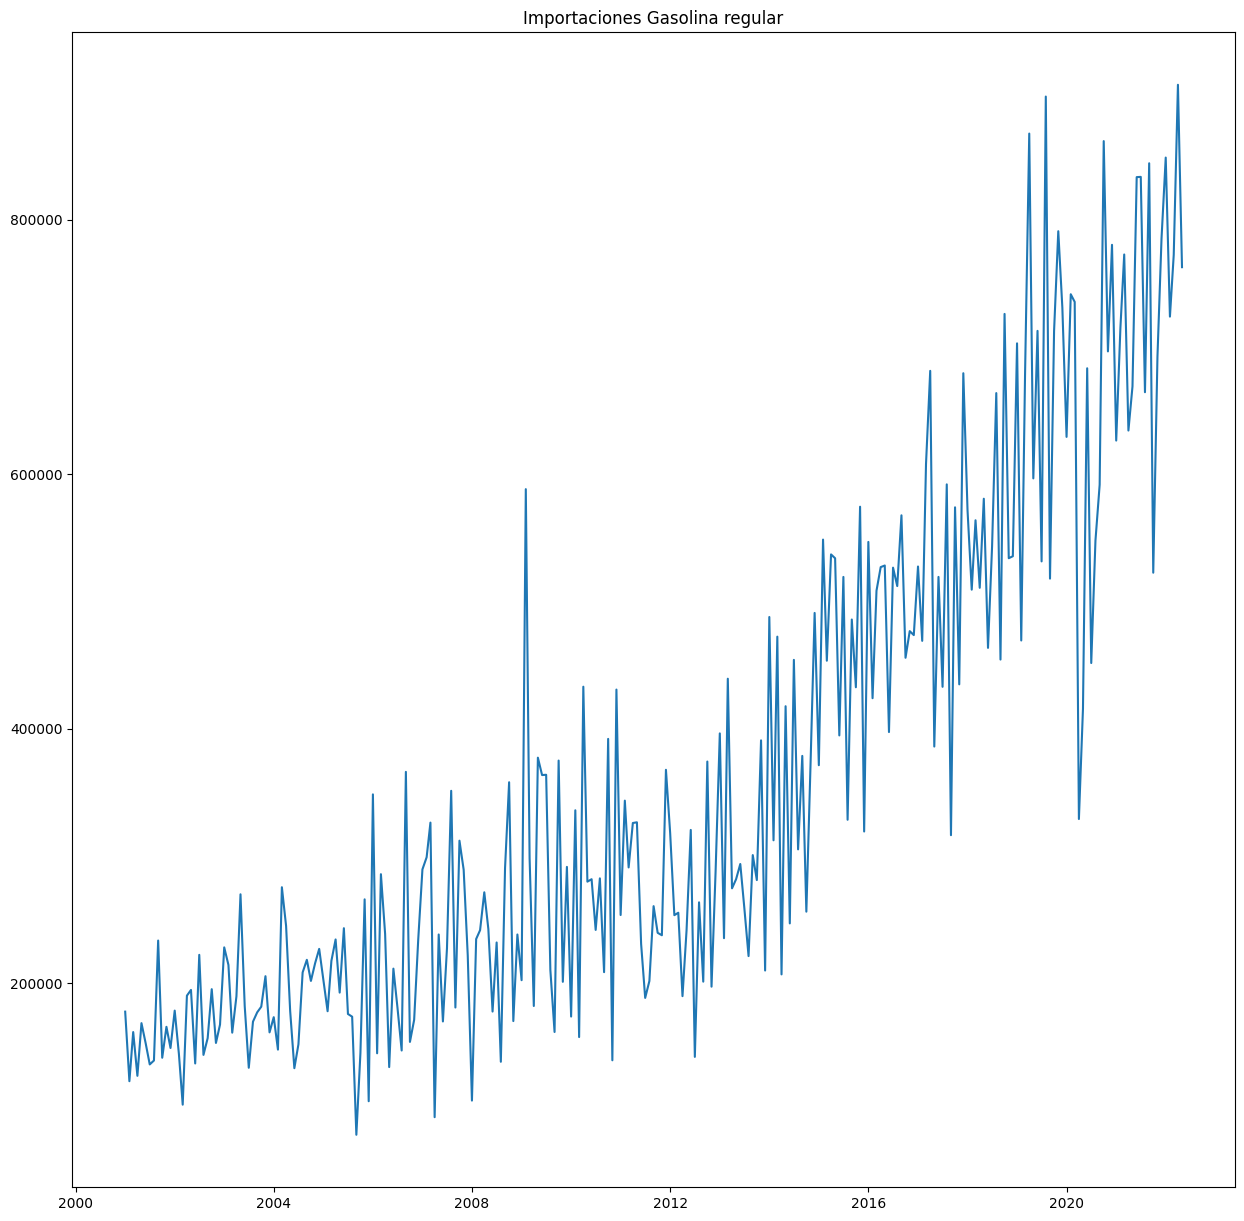

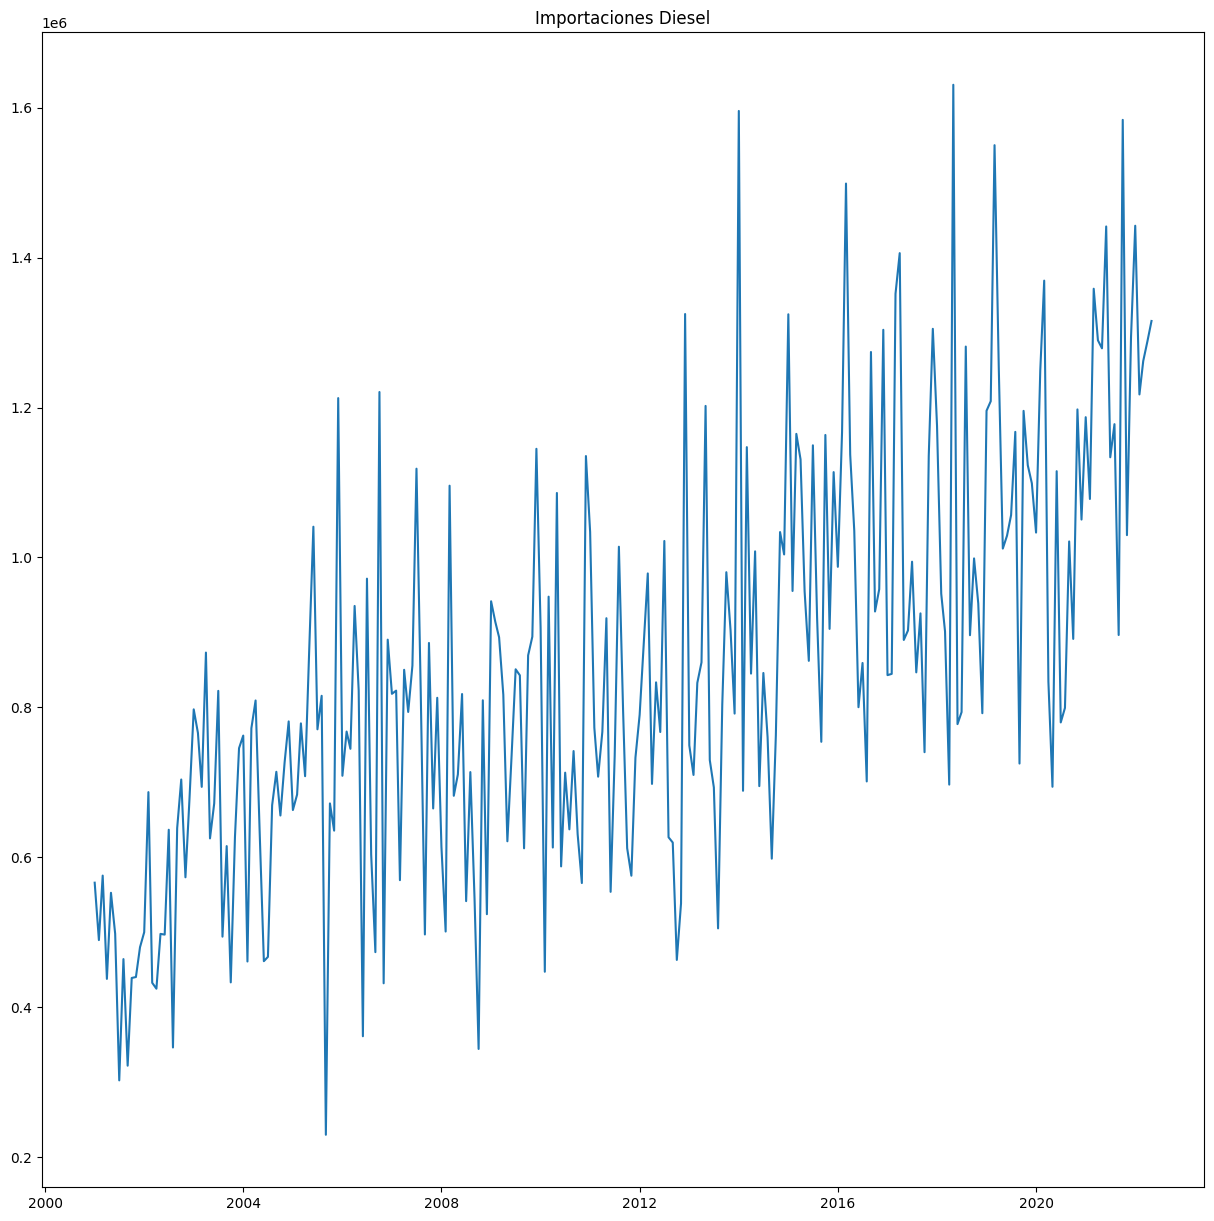

In [17]:
for x in interes:
    figure = plt.figure()
    figure.set_figwidth(15)
    figure.set_figheight(15)
    plt.plot(consumos['Fecha'], consumos[x], label="consumos")
    plt.title(f'Consumos {x}')
    plt.show()

for x in interes:
    figure = plt.figure()
    figure.set_figwidth(15)
    figure.set_figheight(15)
    plt.plot(importes['Fecha'], importes[x], label="Importaciones")
    plt.title(f'Importaciones {x}')
    plt.show()

# Separacion para entrenamiento (Consumo Diesel)

In [18]:
trainSize = int(len(consumos) * 0.7)
trainConsumos = consumos[0:trainSize]
testConsumos = consumos[trainSize:len(consumos)]
trainConsumos = trainConsumos.set_index(['Fecha'])
testConsumos = testConsumos.set_index(['Fecha'])

In [19]:
tsDiesel = trainConsumos['Diesel']
mediaMovil = tsDiesel.rolling(window=12).mean()
deMovil = tsDiesel.rolling(window=12).std()

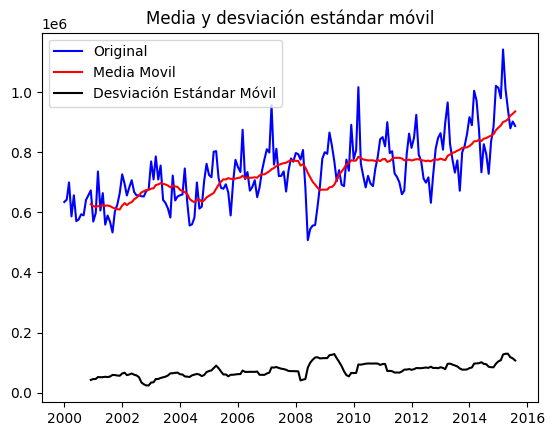

In [20]:
original = plt.plot(tsDiesel, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

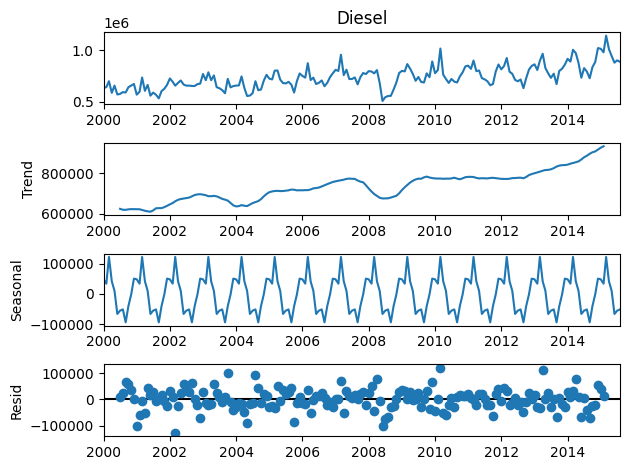

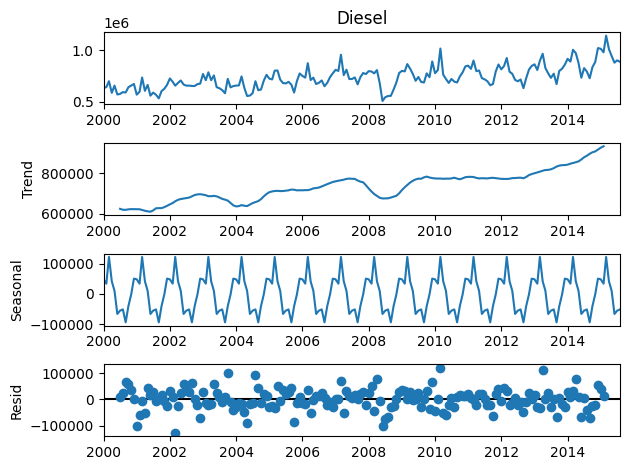

In [21]:
descomposicion = seasonal_decompose(tsDiesel)
descomposicion.plot()

La serie parece no ser estacionaria en media ni varianza debido a la tendencia observada

## Estimacion

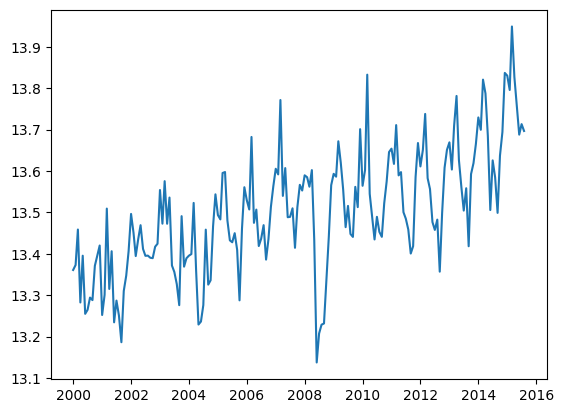

In [22]:
tsDiesel = tsDiesel.astype({'Diesel':'float'})
tsDieselLog = np.log(tsDiesel)
plt.plot(tsDieselLog)

Se realiza una transformacion logaritmica

## Dickey Fuller

In [23]:
dfTest = adfuller(tsDiesel, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Valor Crítico (%s)'%key] = value
print(salidaDf)

Estadístico de prueba         -0.141801
p-value                        0.945112
# de retardos usados          12.000000
# de observaciones usadas    175.000000
Valor Crítico (1%)            -3.468280
Valor Crítico (5%)            -2.878202
Valor Crítico (10%)           -2.575653
dtype: float64


El p-value es mayor a 0.05 por lo que se realizara una diferenciacion

## Resultados del Test de Dickey Fuller para una diferenciación de serie

In [24]:
tsDieselDiff = tsDiesel.diff()
tsDieselDiff.dropna(inplace=True)
dfTest = adfuller(tsDieselDiff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
salidaDf

Estadístico de prueba         -5.536570
p-value                        0.000002
# de retardos usados          11.000000
# de observaciones usadas    175.000000
Critical Value (1%)           -3.468280
Critical Value (5%)           -2.878202
Critical Value (10%)          -2.575653
dtype: float64

El p-value es menor a 0.05, por lo que solo una diferenciacion es necesaria

Text(0.5, 1.0, 'Diferenciacion de la serie')

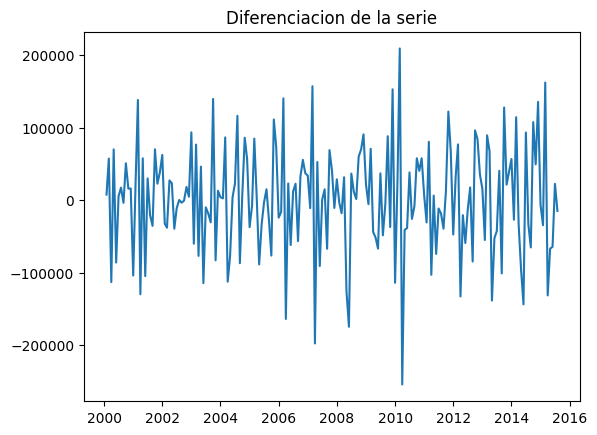

In [25]:
plt.plot(tsDieselDiff)
plt.title('Diferenciacion de la serie')

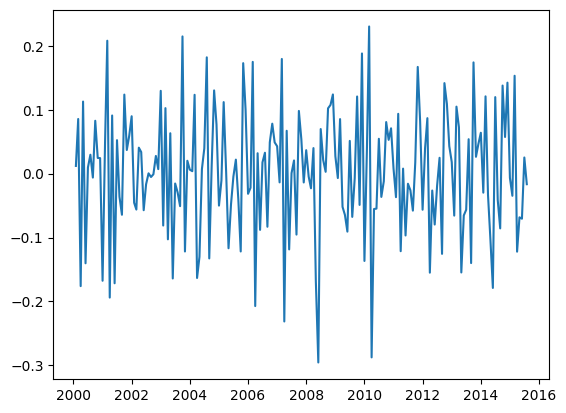

In [26]:
plt.plot(tsDieselLog.diff())

### Estimacion de parametros del modelo

In [27]:
tsDieselLogDiff = tsDieselLog.diff()
tsDieselLogDiff.dropna(inplace = True)
tsd_acf = acf(tsDieselLogDiff,nlags=5,fft=False)
tsd_pacf = pacf(tsDieselLogDiff, nlags=36)
tsd_acf

array([ 1.        , -0.24519488,  0.02136512,  0.03082292, -0.08536819,
        0.05185545])

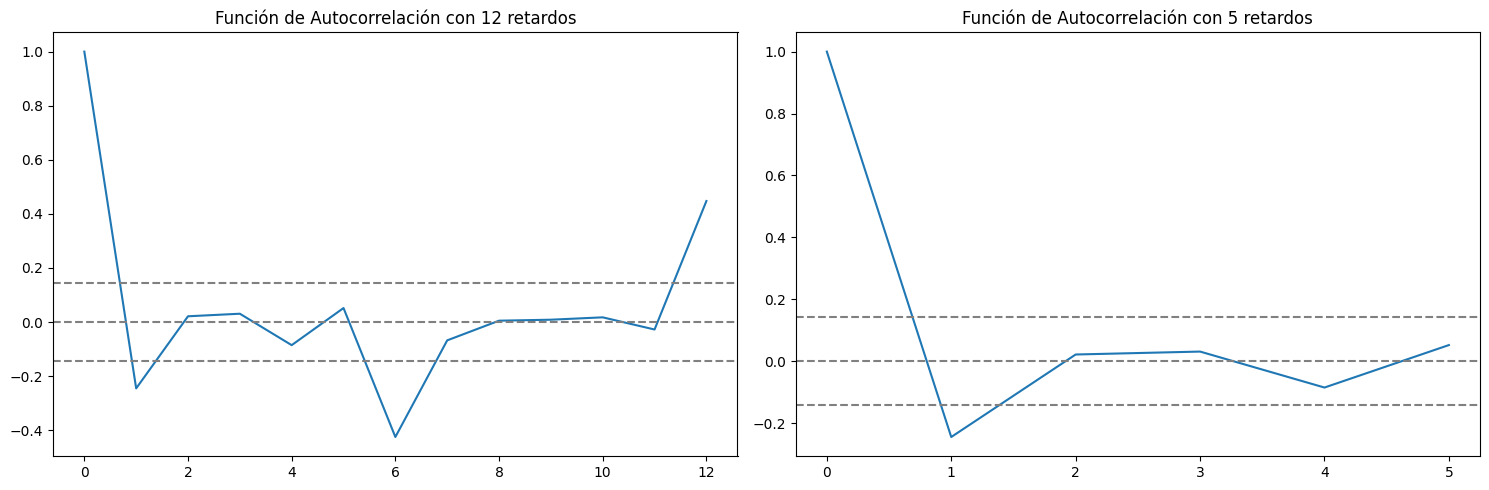

In [28]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(tsDieselLogDiff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(tsDieselLogDiff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

### PACF

In [ ]:
plt.subplot(121)
plt.plot(pacf(tsDieselLogDiff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(tsDieselLogDiff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 

En los graficos anteriores, se obtienen los siguientes valores

    p = 1, q = 1
    p = 1, q = 1

Y se tiene que d = 1

## ARIMA

### Prueba de estacionalidad

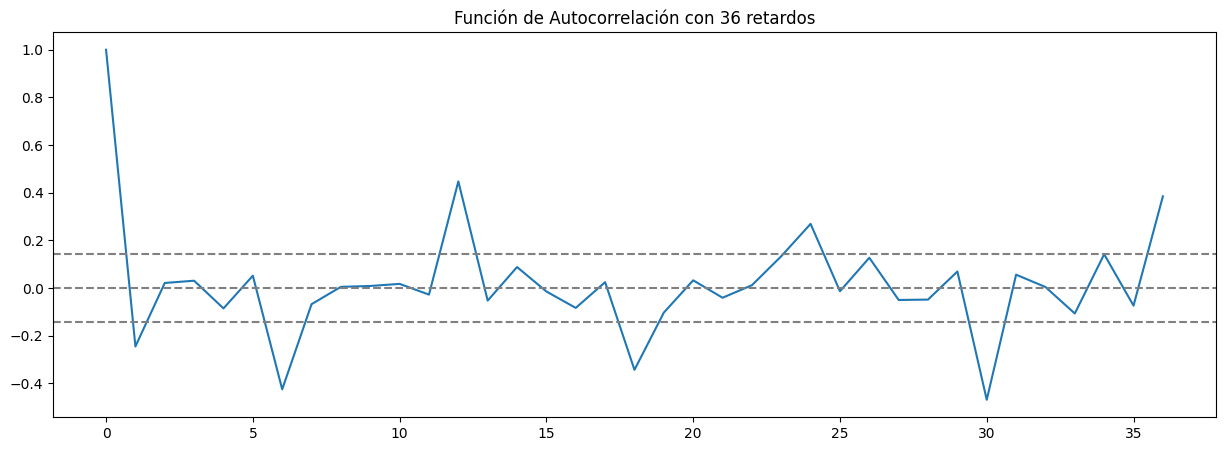

In [30]:
plt.plot(acf(tsDieselLogDiff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Se observa estacionalidad aproximadamente cada doce meses (6, 18, 30)

In [31]:
tsDieselD = tsDieselLog.diff(12)
tsDieselD.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

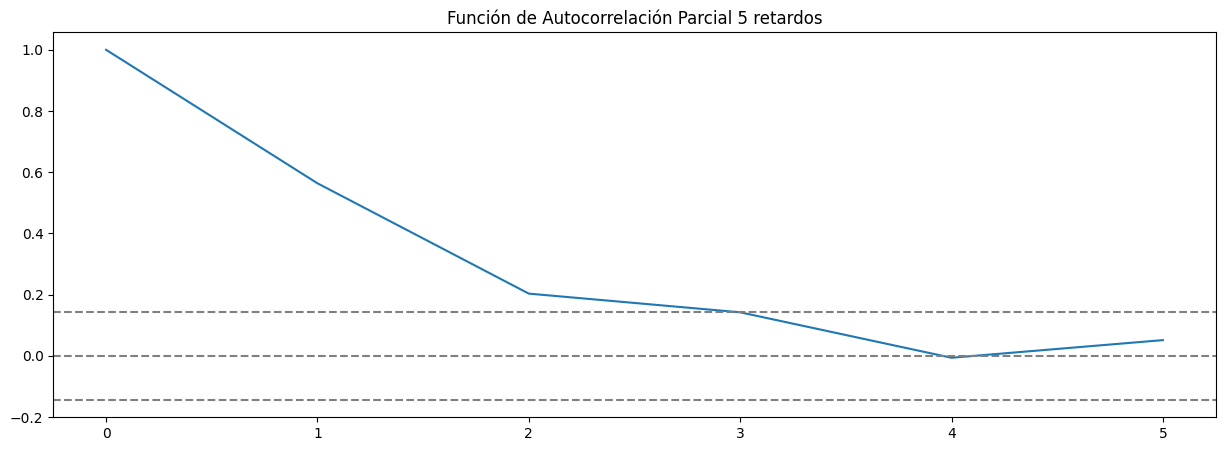

In [32]:
plt.plot(pacf(tsDieselD, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

Se anula despues de 3
P = 3
D = 1
Q = 0

In [33]:
modelo111 = SARIMAX(tsDieselLog, order=(1,1,1), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m111 = modelo111.fit()
resultado_m111.summary().tables[1]

C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.0315,0.162,0.194,0.846,-0.286,0.349
ma.L1,-0.6126,0.119,-5.152,0.000,-0.846,-0.380
ar.S.L12,-0.7276,0.087,-8.382,0.000,-0.898,-0.557
ar.S.L24,-0.5636,0.103,-5.480,0.000,-0.765,-0.362
ar.S.L36,-0.3038,0.086,-3.527,0.000,-0.473,-0.135
sigma2,0.0048,0.000,11.515,0.000,0.004,0.006


### Analisis de residuos

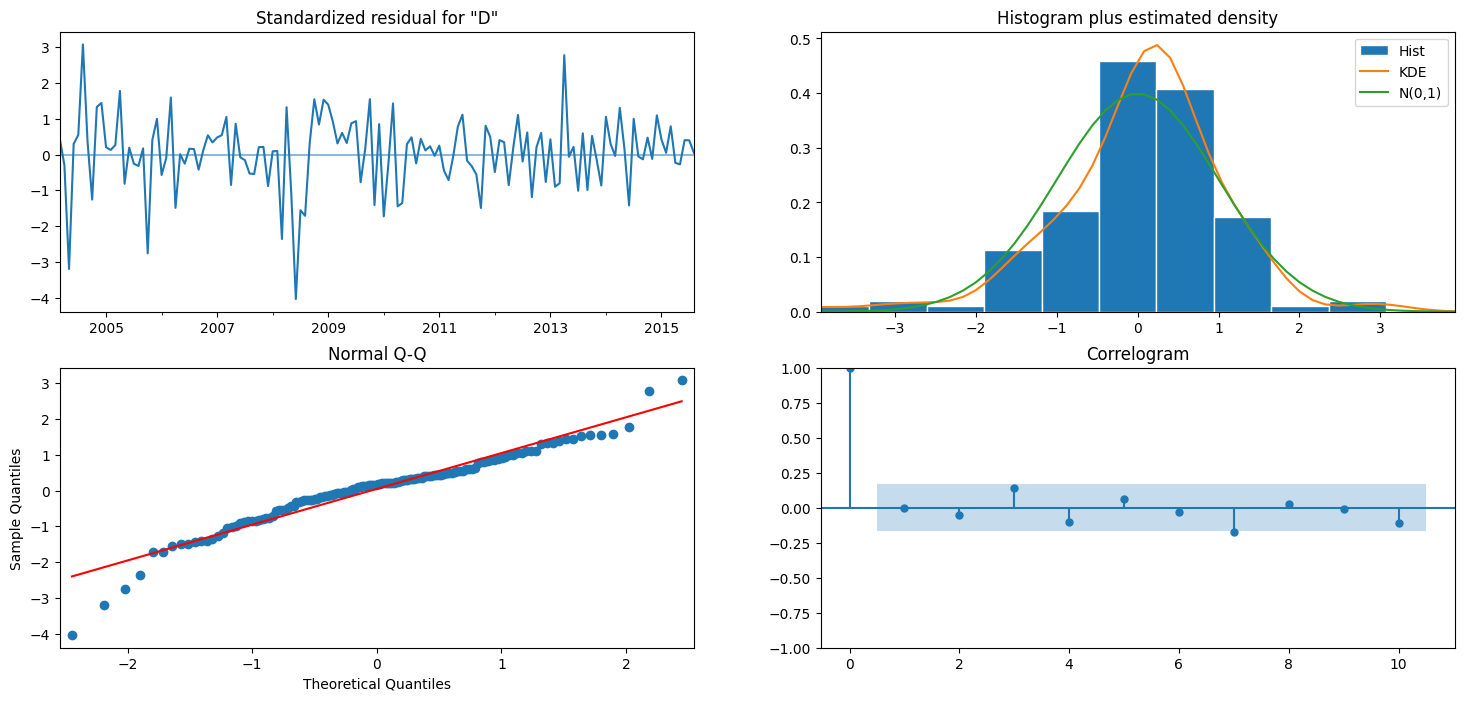

In [34]:
resultado_m111.plot_diagnostics(figsize=(18, 8))
plt.show()

In [35]:
modelo211 = SARIMAX(tsDieselLog, order=(2,1,1), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m211 = modelo211.fit()
resultado_m211.summary().tables[1]

C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.3513,0.198,-1.778,0.075,-0.738,0.036
ar.L2,-0.2556,0.090,-2.841,0.004,-0.432,-0.079
ma.L1,-0.2162,0.199,-1.088,0.276,-0.605,0.173
ar.S.L12,-0.7243,0.092,-7.902,0.000,-0.904,-0.545
ar.S.L24,-0.5526,0.106,-5.198,0.000,-0.761,-0.344
ar.S.L36,-0.2976,0.092,-3.245,0.001,-0.477,-0.118
sigma2,0.0048,0.000,11.259,0.000,0.004,0.006


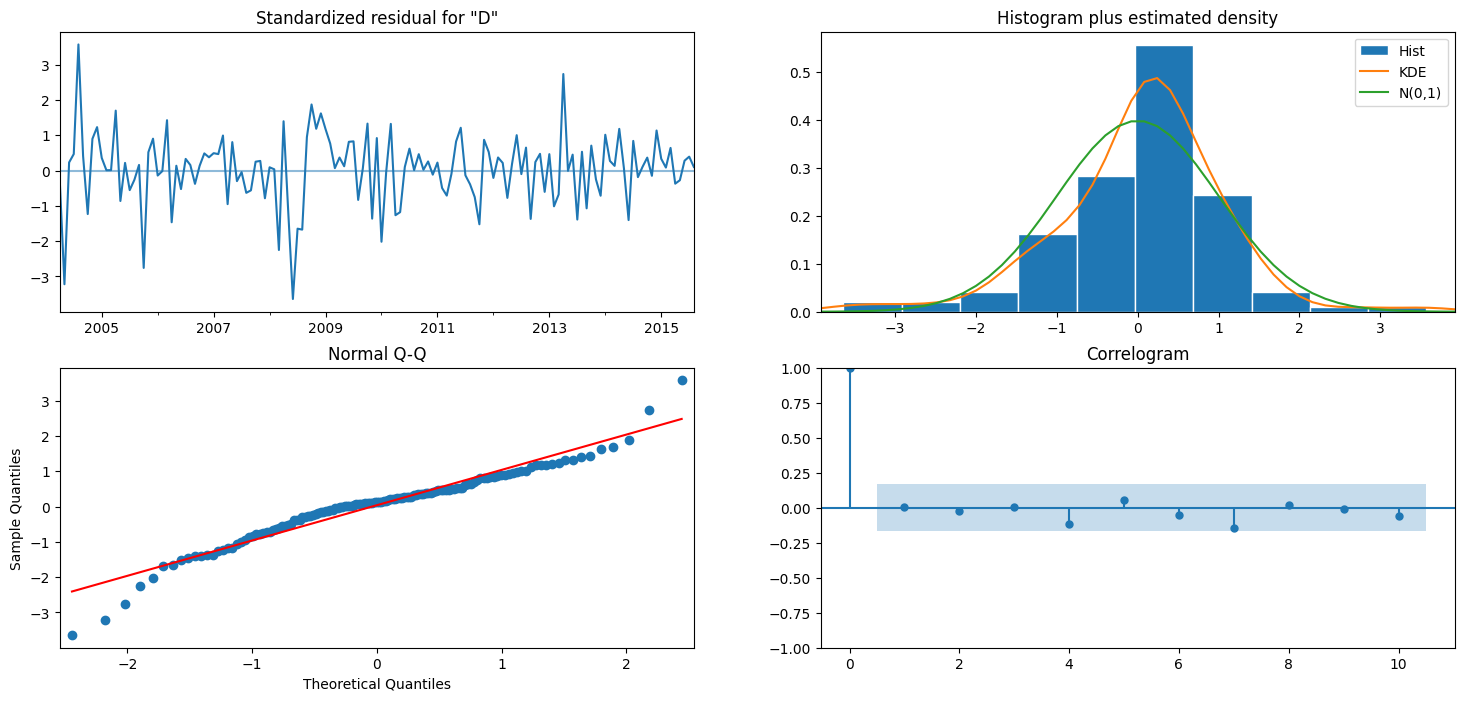

In [36]:
resultado_m211.plot_diagnostics(figsize=(18, 8))
plt.show()

In [37]:
plt.show()
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 111=",resultado_m111.aic)
print("Modelo 211=",resultado_m211.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 111=",resultado_m111.bic)
print("Modelo 211=",resultado_m211.bic)

Resultados de AIC (Akaike information criterion)
Modelo 111= -333.40944630859326
Modelo 211= -330.02835172625487
Resultados de BIC (Bayesian information criterion)
Modelo 111= -315.84592419765005
Modelo 211= -309.588485245458


El modelo 111 es mejor porque en ambos el valor es menor

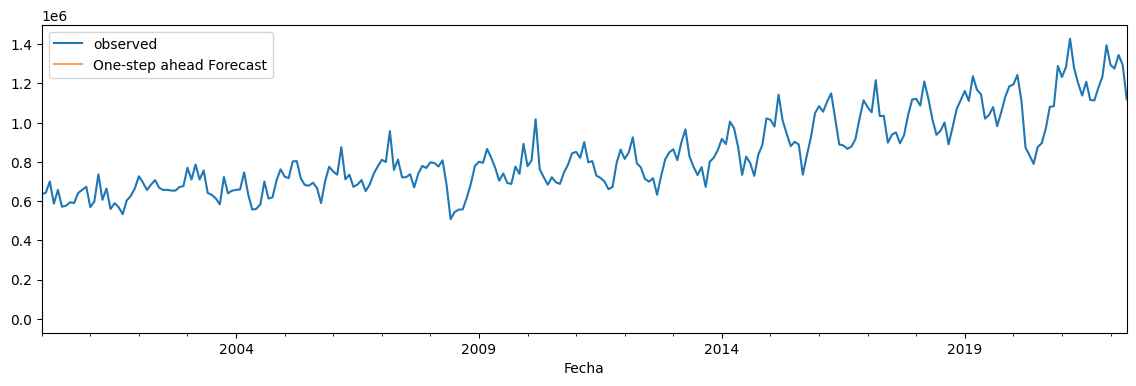

In [45]:
testConsumos.index[0]
pred = resultado_m111.get_prediction(start=testConsumos.index[0], dynamic=False)
pred_ci = pred.conf_int()
consumoIndexed = consumos.set_index('Fecha')
consumoIndexed = consumoIndexed['Diesel']
ax = consumoIndexed['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between( pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
#ax.set_xlabel('Date')
#ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

pred